# PCA Analysis with clustering

This is a notebook to go through the basics of PCA analysis with clustering

In [54]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from functions.data_functions import load_data
import warnings
warnings.filterwarnings(action='ignore')

THe following cell loads the data. Merges dataframes using left joins into one dataframe then splits the data into the two groups.

In [55]:
t1_ede_q_df = load_data('BEACON', 'edeq_t1')
t1_hads_df = load_data('BEACON', 'hads_t1')
t1_oci_df = load_data('BEACON', 'oci_t1')
t1_bmi_df = load_data('BEACON', 'bmi_t1')

edeq_hads = t1_hads_df.merge(t1_ede_q_df, on='PPT ID', how='left')
edeq_hads = edeq_hads.rename(columns={'PPT ID':'G-Number'})
oci_bmi = t1_oci_df.merge(t1_bmi_df, on='G-Number', how='left')
t1_df = oci_bmi.merge(edeq_hads, on='G-Number', how='left')

scores_t1 = t1_df[t1_df['G-Number'].str.contains('G1')].drop(['G-Number', 'group_x_x', 'group_x_y', 'group_y_x', 'group_y_y', 'index_x_x', 'index_y_x', 'index_x_y', 'index_y_y'], axis=1)

In [56]:
scores_t1

,Initial_OCI_Total_score,BMI_baseline,anxiety,depression,Restraint,Eating Concern,Shape Concern,Weight Concern,Total Score
0,3.0,18.328742,4.0,0.0,0.0,0.0,0.000,0.0,0.00
1,3.0,20.202020,4.0,3.0,0.2,0.0,0.500,0.4,0.28
2,4.0,21.011758,6.0,9.0,0.0,0.0,0.750,0.4,0.29
3,2.0,NaN,2.0,6.0,0.0,0.2,1.125,0.8,0.53
4,3.0,24.609375,9.0,4.0,0.0,0.0,0.125,0.2,0.08
...,...,...,...,...,...,...,...,...,...
68,2.0,23.588329,0.0,1.0,0.0,0.0,0.750,1.0,0.44
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,20.0,26.573129,9.0,6.0,1.0,1.2,3.875,2.2,2.07
71,6.0,19.918367,3.0,2.0,1.2,0.0,2.625,1.2,1.26


## Preprocessing

Due to the data being in different units this can cause some measures to be weighted more in the segmentation model compared with others. For example a difference in the ede-q between HC participants could be 0.5 however there could be a difference of 10 between the lowest and highest BMI.

To prevent this all the data is standardized by removing the mean and scaling to unit variance.

```z = (x - u) / s```

Where u is the mean and s is the standard variaces. 

In [58]:
scaler = StandardScaler()
scores_std = scaler.fit_transform(scores_t1.dropna())

## Dimensionality Reduction


If our data has too many features and possibly not enough data points then it needs it features reduced. So going from 3 features plotted in a 3D plane down to 2 features plotted 2D. In the real world if we have multiple measures that all measure the same thing (in our case anorexia) then it makes sense to reduce them down to a few.

PCA analysis is a form of dimension reduction that formally tries to find the best possible subspace which explains most of the variance in the data. It transforms the variables into new ones called components and we try to keep as little of the components as possible while retaining as much of the original information as possible.


In [60]:
pca_model = PCA()
pca_model.fit(scores_std)
pca_scores = pca_model.transform(scores_std)

In [61]:
pca_model.explained_variance_ratio_

array([5.92816103e-01, 1.81096213e-01, 7.45933516e-02, 5.47116043e-02,
       3.72631989e-02, 2.59137212e-02, 2.43469970e-02, 9.25768761e-03,
       1.12347698e-06])

We can then plot the number of components by explained variance.

Text(0, 0.5, 'Cumulative Explained variance')

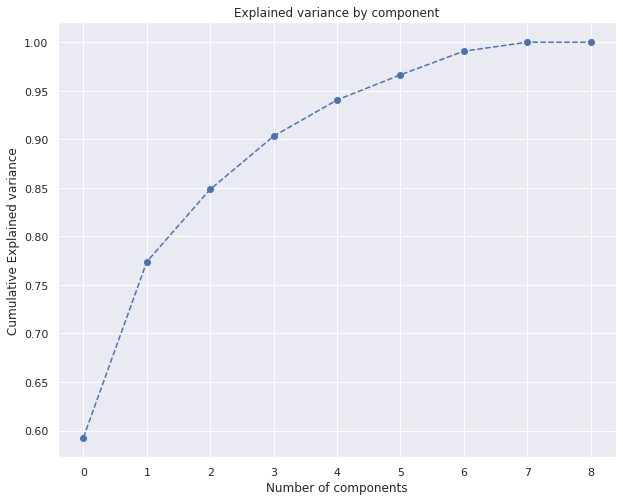

In [62]:
plt.figure(figsize=(10,8))
plt.plot(pca_model.explained_variance_ratio_.cumsum(), marker='o', linestyle='--' )
plt.title('Explained variance by component')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained variance')

As a rule it is good to keep the components that explain 80% of the variance. So we could just keep the first two components. However we could also it another way.

## K-means clustering and PCA analysis to decide the number of clusters

Once the PCA analysis has run we need to decide the number of components we are going to keep. To do this we will use k-means clustering to cluster the PCA components and then the elbow method to determine the number of clusters to keep.

In order to do this we run the pca on different number of k-means clusters. We then determine the the Within Cluster Sum of Squares and plot the values. To determine the number of clusters we look for an elbow/kink in the plot and that determines the number of clusters we are going to keep. Basic rule of thumb is the part before the kink is a steep decline

In [64]:
wcss = []

for cluster_number in range(1,21):
    kmeans_pca = KMeans(n_clusters=cluster_number, random_state=42)
    kmeans_pca.fit(pca_scores)
    wcss.append(kmeans_pca.inertia_)

Text(0, 0.5, 'WCSS')

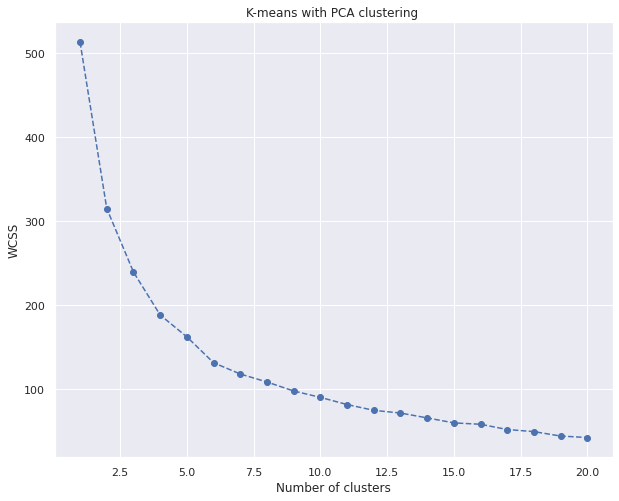

In [65]:
plt.figure(figsize=(10,8))
plt.plot(range(1,21), wcss, marker='o', linestyle='--')
plt.title('K-means with PCA clustering ')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

## Components to keep

Both the standard PCA plotting and the K means indicate that the number of clusters/components to keep is the first two. 

We then run the kmeans on the pca scores and indicate we only want to keep the first two clusters.

In [66]:
kmeans_pca = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans_pca.fit(pca_scores)

KMeans(n_clusters=2, random_state=42)

## Dataframe

Now we can put all the data into a dataframe and can plot the first two components with the segmented k-means as a hue.

In [67]:
df_seg = pd.concat([scores_t1.dropna().reset_index(drop=True), pd.DataFrame(pca_scores)], axis=1)

df_seg.columns.values[9:11] = ['comp_1', 'comp_2']
df_seg['segemented_k_means'] = kmeans_pca.labels_
df_seg['segment'] = df_seg['segemented_k_means'].map({0:'first', 1:'second'})
df_seg.head()

,Initial_OCI_Total_score,BMI_baseline,anxiety,depression,Restraint,Eating Concern,Shape Concern,Weight Concern,Total Score,comp_1,comp_2,2,3,4,5,6,7,8,segemented_k_means,segment
0,3.0,18.328742,4.0,0.0,0.0,0.0,0.000,0.0,0.00,-1.984548,0.249518,1.198419,0.286467,0.053540,0.400809,-0.304920,-0.084035,0.000119,0,first
1,3.0,20.202020,4.0,3.0,0.2,0.0,0.500,0.4,0.28,-1.029682,0.361162,0.264057,0.267674,-0.259341,-0.077614,0.235237,-0.121548,0.005705,0,first
2,4.0,21.011758,6.0,9.0,0.0,0.0,0.750,0.4,0.29,-0.308572,1.873582,-1.159635,0.051679,-0.310540,-0.497496,1.120080,-0.158264,0.002412,0,first
3,3.0,24.609375,9.0,4.0,0.0,0.0,0.125,0.2,0.08,-0.792431,0.697774,-1.541330,-0.028096,0.102489,0.315116,-0.841623,0.263687,-0.001417,0,first
4,3.0,22.718974,1.0,0.0,0.0,0.0,0.375,0.2,0.14,-1.661179,-1.161475,0.220720,-0.158566,0.059885,0.106452,0.068947,-0.053001,-0.005125,0,first


<AxesSubplot:xlabel='comp_1', ylabel='comp_2'>

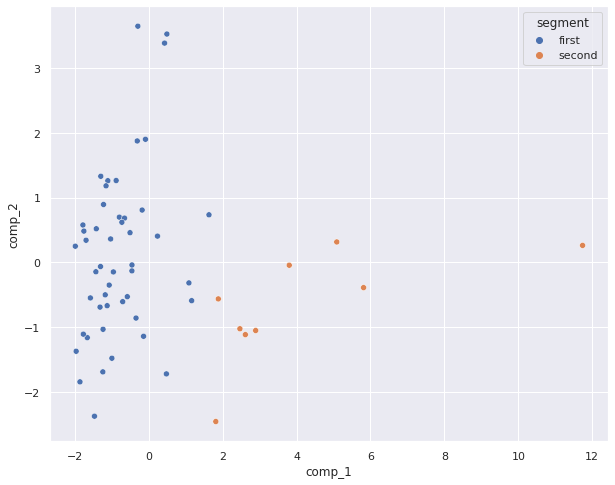

In [68]:
plt.figure(figsize=(10,8))
sns.scatterplot('comp_1', 'comp_2', data=df_seg, hue='segment')

,Initial_OCI_Total_score,BMI_baseline,anxiety,depression,Restraint,Eating Concern,Shape Concern,Weight Concern,Total Score,comp_1,comp_2,2,3,4,5,6,7,8,segemented_k_means
Initial_OCI_Total_score,1.000000,1.049565e-01,4.874603e-01,3.762005e-01,0.499888,0.623316,0.683301,0.663303,0.684940,7.730865e-01,1.558720e-01,2.318750e-01,-4.637117e-01,2.940931e-01,-1.410198e-01,-5.352623e-02,2.075527e-03,5.187918e-06,0.587483
BMI_baseline,0.104957,1.000000e+00,-1.700413e-01,-1.009885e-01,0.292156,0.327334,0.325903,0.378929,0.366665,3.375296e-01,-6.728094e-01,-6.315560e-01,-1.389205e-01,8.225053e-02,-1.528078e-02,-8.400479e-02,3.440873e-02,3.569023e-07,0.379178
anxiety,0.487460,-1.700413e-01,1.000000e+00,7.605125e-01,0.328497,0.432413,0.392868,0.455012,0.438250,5.831988e-01,7.156542e-01,-1.566017e-01,4.018844e-02,-4.993991e-02,1.530085e-01,-3.009919e-01,7.125534e-02,4.293522e-07,0.287132
depression,0.376200,-1.009885e-01,7.605125e-01,1.000000e+00,0.236528,0.321190,0.298938,0.308000,0.316010,4.702473e-01,7.285137e-01,-4.032526e-01,3.924109e-02,9.582728e-03,-1.501056e-01,2.447951e-01,-3.787506e-02,3.109727e-08,0.183115
Restraint,0.499888,2.921564e-01,3.284969e-01,2.365277e-01,1.000000,0.751983,0.658611,0.730179,0.853257,8.187253e-01,-1.871475e-01,1.129099e-01,4.431202e-01,1.237853e-01,-2.451843e-01,-8.045700e-02,6.040194e-02,-7.680341e-04,0.646184
Eating Concern,0.623316,3.273345e-01,4.324129e-01,3.211897e-01,0.751983,1.000000,0.745552,0.730401,0.843571,8.732394e-01,-9.949925e-02,2.825662e-02,1.614326e-01,2.842166e-01,3.170668e-01,1.252760e-01,-6.073983e-02,-3.028062e-04,0.630732
Shape Concern,0.683301,3.259029e-01,3.928678e-01,2.989385e-01,0.658611,0.745552,1.000000,0.886297,0.936770,9.069204e-01,-1.385000e-01,1.030786e-01,-1.563798e-01,-2.514419e-01,7.218616e-02,1.657326e-01,1.653211e-01,-1.027131e-03,0.836213
Weight Concern,0.663303,3.789290e-01,4.550120e-01,3.079998e-01,0.730179,0.730401,0.886297,1.000000,0.950714,9.264331e-01,-1.397328e-01,2.647367e-02,-6.421957e-02,-2.586258e-01,-3.181628e-02,-9.240461e-02,-2.023175e-01,-9.200140e-04,0.810375
Total Score,0.684940,3.666652e-01,4.382500e-01,3.160103e-01,0.853257,0.843571,0.936770,0.950714,1.000000,9.740952e-01,-1.623959e-01,8.186129e-02,6.266764e-02,-1.153899e-01,-1.703890e-02,2.251847e-02,4.234122e-03,2.743770e-03,0.833737
comp_1,0.773086,3.375296e-01,5.831988e-01,4.702473e-01,0.818725,0.873239,0.906920,0.926433,0.974095,1.000000e+00,6.142726e-17,-3.704975e-17,-2.102961e-16,-3.465531e-16,2.619143e-17,3.692870e-16,-2.015722e-16,-4.568452e-14,0.794105
